https://colab.research.google.com/drive/1SsD7Z2Te39DyGYyJd517eYL2JnLmmDG3?usp=sharing

## Post Sentiment Classification Task

In [3]:
import pandas as pd
import numpy as np

train_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_train.json")

validation_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_validation.json")

test_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_test.json")

In [4]:
#Importing libraries 
import spacy
import nltk
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix ,precision_score, recall_score, accuracy_score, fbeta_score, SCORERS

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer



In [5]:
train_data.head()

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity
0,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7f317,https://www.reddit.com/r/relationships/comment...,Melodrama_,"It's a sad realization, isn't it?",,False,2,t1_cy7erc5,negative,1.000000
1,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hlyf,https://www.reddit.com/r/relationships/comment...,Melodrama_,I told her a couple of minutes ago that I didn...,elaboration,False,2,t1_cy7erc5,neutral,0.483631
2,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7etrr,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Leeches don't make good friends.,answer,False,1,t3_3xshx9,positive,0.600000
3,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hhpq,https://www.reddit.com/r/relationships/comment...,Melodrama_,I just ended it. Apparently she wasn't a good ...,elaboration,False,2,t1_cy7etrr,positive,0.475000
4,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7q0qg,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Good for you! Make sure you stick with it.,appreciation,False,3,t1_cy7hhpq,positive,0.744444


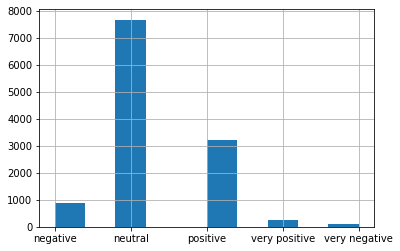

In [6]:
train_data['sentiment.polarity'].hist()

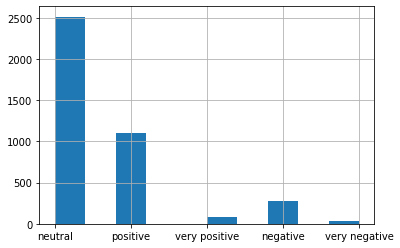

In [7]:
test_data['sentiment.polarity'].hist()

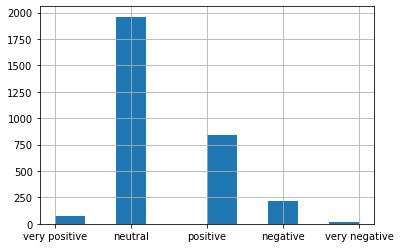

In [8]:
validation_data['sentiment.polarity'].hist()

In [9]:


number_neutral_train = sum(train_data['sentiment.polarity'].__eq__('neutral'))
number_neutral_validation = sum(validation_data['sentiment.polarity'].__eq__('neutral'))
number_neutral_test = sum(test_data['sentiment.polarity'].__eq__('neutral'))

number_very_negative_train = sum(train_data['sentiment.polarity'].__eq__('very negative'))
number_very_negative_validation = sum(validation_data['sentiment.polarity'].__eq__('very negative'))
number_very_negative_test = sum(test_data['sentiment.polarity'].__eq__('very negative'))

number_positive_train = sum(train_data['sentiment.polarity'].__eq__('positive'))
number_positive_validation = sum(validation_data['sentiment.polarity'].__eq__('positive'))
number_positive_test = sum(test_data['sentiment.polarity'].__eq__('positive'))

print('----Training set----')
print('Total posts - {:d}'.format(len(train_data)))
print('Fraction of neutral posts -  %0.0f%% ' % (100*number_neutral_train/len(train_data)))
print('Fraction of very negative posts -  %0.0f%% ' % (100*number_very_negative_train/len(train_data)))
print('Fraction of positive posts -  %0.0f%% ' % (100*number_positive_train/len(train_data)))

print('----Validation set----')
print('Total posts - {:d}'.format(len(validation_data)))
print('Fraction of neutral posts -  %0.0f%% ' % (100*number_neutral_validation/len(validation_data)))
print('Fraction of very negative posts -  %0.0f%% ' % (100*number_very_negative_validation/len(validation_data)))
print('Fraction of positive posts -  %0.0f%% ' % (100*number_positive_validation/len(validation_data)))


print('----Test set----')
print('Total posts - {:d}'.format(len(test_data)))
print('Fraction of neutral posts -  %0.0f%% ' % (100*number_neutral_test/len(test_data)))
print('Fraction of very negative posts -  %0.0f%% ' % (100*number_very_negative_test/len(test_data)))
print('Fraction of positive posts -  %0.0f%% ' % (100*number_positive_test/len(test_data)))


----Training set----
Total posts - 12138
Fraction of neutral posts -  63% 
Fraction of very negative posts -  1% 
Fraction of positive posts -  27% 
----Validation set----
Total posts - 3109
Fraction of neutral posts -  63% 
Fraction of very negative posts -  0% 
Fraction of positive posts -  27% 
----Test set----
Total posts - 4016
Fraction of neutral posts -  63% 
Fraction of very negative posts -  1% 
Fraction of positive posts -  27% 


In [10]:
train_labels = train_data['sentiment.polarity']
validation_labels = validation_data['sentiment.polarity']
test_labels = test_data['sentiment.polarity']

In [11]:

one_hot_vectorizer = CountVectorizer(binary=True)

train_features = one_hot_vectorizer.fit_transform(train_data['body'])
validation_features = one_hot_vectorizer.transform(validation_data['body'])
test_features = one_hot_vectorizer.transform(test_data['body'])

In [12]:
ngram_vectorizer = TfidfVectorizer()

train_features_tf_idf = ngram_vectorizer.fit_transform(train_data['body'])
test_features_tf_idf = ngram_vectorizer.transform(test_data['body'])
validation_features_tf_idf = ngram_vectorizer.transform(validation_data['body'])

In [13]:

#metrics = {}
def evaluation_summary(description, predictions, true_labels):
  values = []
  accuracy = accuracy_score(predictions, true_labels)
  values.append('%.3f'%(accuracy))
  precision = precision_score(predictions, true_labels, average='macro')
  values.append('%.3f'%(precision))
  recall = recall_score(predictions, true_labels, average='macro')
  values.append('%.3f'%(recall))
  macro_f1 = fbeta_score(predictions, true_labels, 1, average = 'macro') 
  values.append('%.3f'%(macro_f1))
  weighted_f1 = fbeta_score(predictions, true_labels, 1, average = 'weighted') 
  values.append('%.3f'%(weighted_f1))
 
  metrics[description] = values

  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,macro_f1))
  print(classification_report(predictions, true_labels, digits=3, zero_division = 0))
  print("----------------------------")


In [30]:
# a)
dummy_mf = DummyClassifier(strategy='most_frequent')
dummy_mf.fit(train_features, train_labels)
predicted_test_labels_a = dummy_mf.predict(test_features)
predicted_train_labels_a = dummy_mf.predict(train_features)

# b)
dummy_prior = DummyClassifier(strategy='stratified')
dummy_prior.fit(train_features, train_labels)
predicted_test_labels_b = dummy_prior.predict(test_features)
predicted_train_labels_b = dummy_prior.predict(train_features)
# c)
logistic_regression = LogisticRegression(solver='saga', max_iter = 1000)
logistic_regression.fit(train_features, train_labels)
predicted_test_labels_c = logistic_regression.predict(test_features)
predicted_train_labels_c = logistic_regression.predict(train_features)
# d)
lr_model = LogisticRegression(solver='saga',max_iter = 1000)
lr_model.fit(train_features_tf_idf, train_labels)
predicted_test_labels_d = lr_model.predict(test_features_tf_idf)
predicted_train_labels_d = lr_model.predict(train_features_tf_idf)
# e)
svc_model = svm.SVC(kernel = 'rbf')
svc_model.fit(train_features, train_labels)
predicted_test_labels_e = svc_model.predict(test_features)
predicted_train_labels_e = svc_model.predict(train_features)
# f) 

dtc = tree.DecisionTreeClassifier(random_state = 0, max_depth= 2)
dtc.fit(train_features_tf_idf, train_labels)
predicted_test_labels_f = dtc.predict(test_features_tf_idf)
predicted_train_labels_f = dtc.predict(train_features_tf_idf)

# bnb = BernoulliNB()
# bnb.fit(train_features, train_labels)
# predicted_test_labels_f = bnb.predict(test_features)
# #OR
# rfc = RandomForestClassifier(n_estimators= 200, max_depth = 3, random_state = 0)
# rfc.fit(train_features_tf_idf, train_labels)
# predicted_test_labels_g = rfc.predict(test_features_tf_idf)

In [31]:
#Evaluation Summary for Training Set
metrics = {}
evaluation_summary('Dummy Classifier (most_frequent)',predicted_train_labels_a, train_labels)
evaluation_summary('Dummy Classifier(stratified)', predicted_train_labels_b, train_labels)
evaluation_summary('LogisticRegression (One-hot vectorization)', predicted_train_labels_c, train_labels)
evaluation_summary('LogisticRegression (TF-IDF vectorization)', predicted_train_labels_d, train_labels)
evaluation_summary('SVC Classifier',  predicted_train_labels_e, train_labels)
evaluation_summary('Decision Tree classifier', predicted_train_labels_f, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier 'Dummy Classifier (most_frequent)' has Acc=0.633 P=0.200 R=0.127 F1=0.155
               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         0
      neutral      1.000     0.633     0.775     12138
     positive      0.000     0.000     0.000         0
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.633     12138
    macro avg      0.200     0.127     0.155     12138
 weighted avg      1.000     0.633     0.775     12138

----------------------------
Classifier 'Dummy Classifier(stratified)' has Acc=0.472 P=0.198 R=0.198 F1=0.198
               precision    recall  f1-score   support

     negative      0.068     0.070     0.069       853
      neutral      0.632     0.628     0.630      7722
     positive      0.251     0.255     0.253      3183
very negative      0.021     0.017     0.019       115
very positive      0.020     0.

In [32]:
#Evaluation Summary for Training Set

df = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['Accuracy','Precision', 'Recall', 'F1(macro)' , 'F1(weighted)'])
def maximum_value_in_column(column):    
    highlight = 'background-color: pink;'
    default = ''
    maximum_in_column = column.max()
    return [highlight if v == maximum_in_column else default for v in column]
df.style.apply(maximum_value_in_column, subset = ['Accuracy','F1(weighted)'], axis=0)

,Accuracy,Precision,Recall,F1(macro),F1(weighted)
Dummy Classifier (most_frequent),0.633,0.200,0.127,0.155,0.775
Dummy Classifier(stratified),0.472,0.198,0.198,0.198,0.473
LogisticRegression (One-hot vectorization),0.964,0.848,0.982,0.904,0.965
LogisticRegression (TF-IDF vectorization),0.817,0.409,0.916,0.461,0.845
SVC Classifier,0.862,0.425,0.751,0.457,0.887
Decision Tree classifier,0.669,0.233,0.285,0.218,0.758


In [33]:
#Evaluation Summary for Tests Set
metrics ={}
evaluation_summary('Dummy Classifier (most_frequent)',predicted_test_labels_a, test_labels)
evaluation_summary('Dummy Classifier(stratified)', predicted_test_labels_b, test_labels)
evaluation_summary('LogisticRegression (One-hot vectorization)', predicted_test_labels_c, test_labels)
evaluation_summary('LogisticRegression (TF-IDF vectorization)', predicted_test_labels_d, test_labels)
evaluation_summary('SVC Classifier',  predicted_test_labels_e, test_labels)
# evaluation_summary('BernoulliNB', predicted_test_labels_f, test_labels)
# evaluation_summary('RandomForestClassifier', predicted_test_labels_g, test_labels)
evaluation_summary('Decision Tree classifier', predicted_test_labels_f, test_labels)

Classifier 'Dummy Classifier (most_frequent)' has Acc=0.626 P=0.200 R=0.125 F1=0.154
               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         0
      neutral      1.000     0.626     0.770      4016
     positive      0.000     0.000     0.000         0
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.626      4016
    macro avg      0.200     0.125     0.154      4016
 weighted avg      1.000     0.626     0.770      4016

----------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier 'Dummy Classifier(stratified)' has Acc=0.479 P=0.203 R=0.203 F1=0.203
               precision    recall  f1-score   support

     negative      0.071     0.075     0.073       265
      neutral      0.630     0.629     0.629      2518
     positive      0.290     0.284     0.287      1125
very negative      0.000     0.000     0.000        29
very positive      0.023     0.025     0.024        79

     accuracy                          0.479      4016
    macro avg      0.203     0.203     0.203      4016
 weighted avg      0.481     0.479     0.480      4016

----------------------------
Classifier 'LogisticRegression (One-hot vectorization)' has Acc=0.745 P=0.437 R=0.641 F1=0.488
               precision    recall  f1-score   support

     negative      0.238     0.472     0.316       142
      neutral      0.877     0.773     0.822      2852
     positive      0.625     0.710     0.665       970
very negative      0.188     0.750     0.300         8
very positive      0.

In [34]:
#Evaluation Summary for Tests Set

df = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['Accuracy','Precision', 'Recall', 'F1(macro)' , 'F1(weighted)'])
def maximum_value_in_column(column):    
    highlight = 'background-color: yellow;'
    default = ''
    maximum_in_column = column.max()
    return [highlight if v == maximum_in_column else default for v in column]
df.style.apply(maximum_value_in_column, subset = ['Accuracy','F1(weighted)'], axis=0)



,Accuracy,Precision,Recall,F1(macro),F1(weighted)
Dummy Classifier (most_frequent),0.626,0.200,0.125,0.154,0.770
Dummy Classifier(stratified),0.479,0.203,0.203,0.203,0.480
LogisticRegression (One-hot vectorization),0.745,0.437,0.641,0.488,0.760
LogisticRegression (TF-IDF vectorization),0.739,0.328,0.583,0.353,0.779
SVC Classifier,0.728,0.288,0.458,0.286,0.781
Decision Tree classifier,0.663,0.233,0.282,0.218,0.752


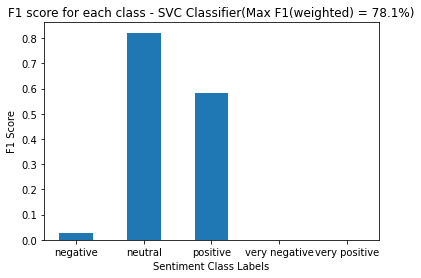

In [25]:
#svc classifier
cr = classification_report(predicted_test_labels_e, test_labels, digits=3, zero_division = 0, output_dict = True)
x = ['negative','neutral','positive', 'very negative', 'very positive']
y = [cr['negative']['f1-score'],cr['neutral']['f1-score'],cr['positive']['f1-score'],cr['very negative']['f1-score'],cr['very positive']['f1-score']]
plt.bar(x,y, width = 0.5)
plt.xlabel("Sentiment Class Labels")
plt.ylabel("F1 Score")
plt.title("F1 score for each class - SVC Classifier(Max F1(weighted) = 78.1%)")
plt.show()

**Improve the effectiveness of the LogisticRegression with TF-IDF vectorization from Q1.**

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [39]:
prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),                 
              ('tfid', TfidfVectorizer()),
              ('logreg', LogisticRegression(solver='saga', max_iter=9000))
              ])
prediction_pipeline.fit(train_data, train_labels)
evaluation_summary("LR", prediction_pipeline.predict(validation_data), validation_labels) 

Classifier 'LR' has Acc=0.731 P=0.320 R=0.564 F1=0.344
               precision    recall  f1-score   support

     negative      0.084     0.581     0.146        31
      neutral      0.938     0.732     0.823      2512
     positive      0.482     0.731     0.581       557
very negative      0.000     0.000     0.000         0
very positive      0.096     0.778     0.171         9

     accuracy                          0.731      3109
    macro avg      0.320     0.564     0.344      3109
 weighted avg      0.846     0.731     0.771      3109

----------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:


from sklearn.model_selection import GridSearchCV
params = {
   'tfid__sublinear_tf': (True, False), 
}
grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='accuracy', cv=2)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

evaluation_summary("LR", grid_search.predict(validation_data), validation_labels) 

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.8s finished


Best score: 0.718
Best parameters set:
	tfid__sublinear_tf: True
Classifier 'LR' has Acc=0.731 P=0.322 R=0.576 F1=0.348
               precision    recall  f1-score   support

     negative      0.093     0.645     0.163        31
      neutral      0.936     0.734     0.823      2500
     positive      0.488     0.724     0.583       569
very negative      0.000     0.000     0.000         0
very positive      0.096     0.778     0.171         9

     accuracy                          0.731      3109
    macro avg      0.322     0.576     0.348      3109
 weighted avg      0.843     0.731     0.770      3109

----------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
params = {
   'tfid__max_features': (10,100,1000,10000,20000),}

grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='accuracy', cv=2)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

evaluation_summary("LR", grid_search.predict(validation_data), validation_labels) 

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.2s finished


Best score: 0.725
Best parameters set:
	tfid__max_features: 1000
Classifier 'LR' has Acc=0.735 P=0.348 R=0.565 F1=0.383
               precision    recall  f1-score   support

     negative      0.107     0.548     0.179        42
      neutral      0.922     0.743     0.823      2432
     positive      0.520     0.710     0.600       618
very negative      0.000     0.000     0.000         0
very positive      0.192     0.824     0.311        17

     accuracy                          0.735      3109
    macro avg      0.348     0.565     0.383      3109
 weighted avg      0.827     0.735     0.767      3109

----------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
params = {
   'tfid__max_features': (10,100,1000,10000,20000),
   'tfid__sublinear_tf': (True, False)}

grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='accuracy', cv=2)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

evaluation_summary("LR", grid_search.predict(validation_data), validation_labels) 

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   17.0s finished


Best score: 0.726
Best parameters set:
	tfid__max_features: 1000
	tfid__sublinear_tf: True
Classifier 'LR' has Acc=0.743 P=0.358 R=0.576 F1=0.396
               precision    recall  f1-score   support

     negative      0.112     0.558     0.186        43
      neutral      0.929     0.749     0.829      2431
     positive      0.533     0.731     0.616       616
very negative      0.000     0.000     0.000         0
very positive      0.219     0.842     0.348        19

     accuracy                          0.743      3109
    macro avg      0.358     0.576     0.396      3109
 weighted avg      0.834     0.743     0.775      3109

----------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
params = {
   'logreg__C': (1e-3,1e-2,1e-1,10,100,1000,10000,1e5)
}
grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='accuracy', cv=2)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

evaluation_summary("LR", grid_search.predict(validation_data), validation_labels) 

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.2min finished


Best score: 0.730
Best parameters set:
	logreg__C: 10
Classifier 'LR' has Acc=0.750 P=0.409 R=0.656 F1=0.461
               precision    recall  f1-score   support

     negative      0.251     0.600     0.354        90
      neutral      0.906     0.765     0.830      2321
     positive      0.573     0.722     0.639       670
very negative      0.067     0.500     0.118         2
very positive      0.247     0.692     0.364        26

     accuracy                          0.750      3109
    macro avg      0.409     0.656     0.461      3109
 weighted avg      0.809     0.750     0.770      3109

----------------------------


In [24]:
params = {
   'logreg__C': (10,100,1000),
   'tfid__max_features': (10,100,1000,10000,20000),
   'tfid__sublinear_tf': (True, False),
   }


grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='accuracy', cv=2)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

evaluation_summary("LR", grid_search.predict(validation_data), validation_labels) 

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.5min finished


Best score: 0.732
Best parameters set:
	logreg__C: 10
	tfid__max_features: 10000
	tfid__sublinear_tf: True
Classifier 'LR' has Acc=0.749 P=0.428 R=0.625 F1=0.480
               precision    recall  f1-score   support

     negative      0.302     0.586     0.399       111
      neutral      0.889     0.775     0.828      2251
     positive      0.594     0.699     0.642       718
very negative      0.133     0.400     0.200         5
very positive      0.219     0.667     0.330        24

     accuracy                          0.749      3109
    macro avg      0.428     0.625     0.480      3109
 weighted avg      0.794     0.749     0.765      3109

----------------------------


In [46]:
improved_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),                 
              ('tfid', TfidfVectorizer(max_features=1000, sublinear_tf= True)),
              ('logreg', LogisticRegression(solver='saga', max_iter=15000, C=10))
              ])
improved_pipeline.fit(train_data, train_labels)
evaluation_summary("LR", improved_pipeline.predict(validation_data), validation_labels) 

Classifier 'LR' has Acc=0.756 P=0.457 R=0.648 F1=0.515
               precision    recall  f1-score   support

     negative      0.265     0.528     0.353       108
      neutral      0.900     0.775     0.833      2275
     positive      0.593     0.730     0.654       686
very negative      0.200     0.500     0.286         6
very positive      0.329     0.706     0.449        34

     accuracy                          0.756      3109
    macro avg      0.457     0.648     0.515      3109
 weighted avg      0.802     0.756     0.772      3109

----------------------------


In [26]:
params = {
   'logreg__class_weight': ('balanced', 'dict'),
   }

grid_search = GridSearchCV(improved_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='accuracy', cv=2)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

evaluation_summary("LR", grid_search.predict(validation_data), validation_labels) 

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set 

Best score: 0.516
Best parameters set:
	logreg__class_weight: 'balanced'
Classifier 'LR' has Acc=0.302 P=0.378 R=0.548 F1=0.240
               precision    recall  f1-score   support

     negative      0.293     0.548     0.382       115
      neutral      0.017     0.846     0.033        39
     positive      0.978     0.294     0.452      2806
very negative      0.467     0.050     0.091       139
very positive      0.137     1.000     0.241        10

     accuracy                          0.302      3109
    macro avg      0.378     0.548     0.240      3109
 weighted avg      0.915     0.302     0.428      3109

----------------------------


In [47]:

params = {
   'tfid__strip_accents': ('ascii', 'unicode'),
   }

grid_search = GridSearchCV(improved_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='accuracy', cv=2)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

evaluation_summary("LR", grid_search.predict(validation_data), validation_labels) 

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.3s finished


Best score: 0.732
Best parameters set:
	tfid__strip_accents: 'unicode'
Classifier 'LR' has Acc=0.756 P=0.457 R=0.648 F1=0.515
               precision    recall  f1-score   support

     negative      0.265     0.528     0.353       108
      neutral      0.900     0.775     0.833      2275
     positive      0.593     0.730     0.654       686
very negative      0.200     0.500     0.286         6
very positive      0.329     0.706     0.449        34

     accuracy                          0.756      3109
    macro avg      0.457     0.648     0.515      3109
 weighted avg      0.802     0.756     0.772      3109

----------------------------


In [48]:
params = {
   'tfid__analyzer': ('word', 'char'),
   }

grid_search = GridSearchCV(improved_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='accuracy', cv=2)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

evaluation_summary("LR", grid_search.predict(validation_data), validation_labels) 

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.3s finished


Best score: 0.731
Best parameters set:
	tfid__analyzer: 'word'
Classifier 'LR' has Acc=0.756 P=0.457 R=0.648 F1=0.515
               precision    recall  f1-score   support

     negative      0.265     0.528     0.353       108
      neutral      0.900     0.775     0.833      2275
     positive      0.593     0.730     0.654       686
very negative      0.200     0.500     0.286         6
very positive      0.329     0.706     0.449        34

     accuracy                          0.756      3109
    macro avg      0.457     0.648     0.515      3109
 weighted avg      0.802     0.756     0.772      3109

----------------------------


In [49]:
params = {
   'logreg__random_state': (0,5,10,15,20,25,30),
   }

grid_search = GridSearchCV(improved_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='accuracy', cv=2)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

evaluation_summary("LR", grid_search.predict(validation_data), validation_labels) 

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   11.2s finished


Best score: 0.731
Best parameters set:
	logreg__random_state: 0
Classifier 'LR' has Acc=0.756 P=0.457 R=0.648 F1=0.515
               precision    recall  f1-score   support

     negative      0.265     0.528     0.353       108
      neutral      0.900     0.775     0.833      2275
     positive      0.593     0.730     0.654       686
very negative      0.200     0.500     0.286         6
very positive      0.329     0.706     0.449        34

     accuracy                          0.756      3109
    macro avg      0.457     0.648     0.515      3109
 weighted avg      0.802     0.756     0.772      3109

----------------------------


In [52]:
final_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),                 
              ('tfid', TfidfVectorizer(max_features=1000, sublinear_tf= True)),
              ('logreg', LogisticRegression(solver='saga', max_iter=15000, C=10, random_state= 0))
              ])
final_pipeline.fit(train_data, train_labels)
evaluation_summary("LR", final_pipeline.predict(validation_data), validation_labels) 

Classifier 'LR' has Acc=0.756 P=0.457 R=0.648 F1=0.515
               precision    recall  f1-score   support

     negative      0.265     0.528     0.353       108
      neutral      0.900     0.775     0.833      2275
     positive      0.593     0.730     0.654       686
very negative      0.200     0.500     0.286         6
very positive      0.329     0.706     0.449        34

     accuracy                          0.756      3109
    macro avg      0.457     0.648     0.515      3109
 weighted avg      0.802     0.756     0.772      3109

----------------------------


In [53]:
evaluation_summary("Final LR", final_pipeline.predict(test_data), test_labels) 
final_df = pd.DataFrame.from_dict(metrics,orient = 'index', columns = ['Accuracy','Precision', 'Recall', 'F1(macro)' , 'F1(weighted)'])
final_df.loc[['Final LR']]


Classifier 'Final LR' has Acc=0.756 P=0.460 R=0.611 F1=0.508
               precision    recall  f1-score   support

     negative      0.241     0.500     0.325       136
      neutral      0.887     0.782     0.831      2850
     positive      0.642     0.732     0.684       966
very negative      0.219     0.500     0.304        14
very positive      0.314     0.540     0.397        50

     accuracy                          0.756      4016
    macro avg      0.460     0.611     0.508      4016
 weighted avg      0.796     0.756     0.771      4016

----------------------------


,Accuracy,Precision,Recall,F1(macro),F1(weighted)
Final LR,0.756,0.460,0.611,0.508,0.771


## **Question 3**
**In this task your goal is to add two features to (try to) improve sentiment polarity classification performance obtained
in Q2.**
You must implement and describe two new classifier features and add them to the tuned model from Q2. Examples include adding other properties of the posts (or threads), leveraging embedding-based features, different vectorization approaches, etc. Train the combined model and report accuracy, macro-averaged precision, recall, and F1 on the test data. Include a well-labeled confusion matrix. Discuss the result in reference to Q2 and what helped (or didn’t) and why you think so.

In [41]:
train_data['subreddit'].value_counts() 
train_data['majority_type'].value_counts()
train_data['title'].value_counts()
train_data['author'].value_counts()

                       1385
AutoModerator            23
FULKRAM                  21
MurderedPigeon           17
seymour1                 16
                       ... 
tdRftw                    1
ohjbird3                  1
Voltron37                 1
machetebrownsugar69       1
tugamawar                 1
Name: author, Length: 7291, dtype: int64

In [55]:
def selecting_features(pipe_line):
  one_hot_train_features = pipe_line.fit_transform(train_data)
  one_hot_validation_features = pipe_line.transform(validation_data)
  one_hot_test_features = pipe_line.transform(test_data)

  lr_model = LogisticRegression(solver='saga', max_iter=15000, C=10, random_state= 0)

  combined = lr_model.fit(one_hot_train_features, train_labels)
  evaluation_summary("Validation LR" , lr_model.predict(one_hot_validation_features), validation_labels) 
  evaluation_summary("Test LR" , lr_model.predict(one_hot_test_features), test_labels)


In [56]:
pipeline_1 = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tdif', TfidfVectorizer(max_features=1000, sublinear_tf= True, strip_accents = 'unicode')), 
              ])),
            ('subreddit', Pipeline([
              ('selector1', ItemSelector(key='subreddit')),
              ('one-hot', TfidfVectorizer( binary=True)), 
              ])),
        ])
        )
    ])
selecting_features(pipeline_1)

Classifier 'Validation LR' has Acc=0.756 P=0.457 R=0.601 F1=0.504
               precision    recall  f1-score   support

     negative      0.288     0.549     0.378       113
      neutral      0.895     0.779     0.833      2253
     positive      0.602     0.728     0.659       699
very negative      0.200     0.300     0.240        10
very positive      0.301     0.647     0.411        34

     accuracy                          0.756      3109
    macro avg      0.457     0.601     0.504      3109
 weighted avg      0.798     0.756     0.771      3109

----------------------------
Classifier 'Test LR' has Acc=0.754 P=0.451 R=0.597 F1=0.495
               precision    recall  f1-score   support

     negative      0.241     0.489     0.323       139
      neutral      0.886     0.781     0.830      2852
     positive      0.636     0.731     0.680       959
very negative      0.188     0.500     0.273        12
very positive      0.302     0.481     0.371        54

     accuracy  

In [57]:
pipeline_2 = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tdif', TfidfVectorizer(max_features=1000, sublinear_tf= True, strip_accents = 'unicode')), 
              ])),
            ('majority_type', Pipeline([
              ('selector1', ItemSelector(key='majority_type')),
              ('one-hot', TfidfVectorizer( binary=True)), 
              ])),
        ])
        )
    ])
selecting_features(pipeline_2)

Classifier 'Validation LR' has Acc=0.752 P=0.450 R=0.589 F1=0.496
               precision    recall  f1-score   support

     negative      0.260     0.514     0.346       109
      neutral      0.895     0.776     0.831      2262
     positive      0.595     0.726     0.654       693
very negative      0.200     0.300     0.240        10
very positive      0.301     0.629     0.407        35

     accuracy                          0.752      3109
    macro avg      0.450     0.589     0.496      3109
 weighted avg      0.797     0.752     0.768      3109

----------------------------
Classifier 'Test LR' has Acc=0.760 P=0.470 R=0.616 F1=0.518
               precision    recall  f1-score   support

     negative      0.241     0.489     0.323       139
      neutral      0.891     0.784     0.834      2857
     positive      0.644     0.746     0.691       952
very negative      0.250     0.533     0.340        15
very positive      0.326     0.528     0.403        53

     accuracy  

In [58]:
pipeline_3 = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tdif', TfidfVectorizer(max_features=1000, sublinear_tf= True, strip_accents = 'unicode')), 
              ])),
            ('author', Pipeline([
              ('selector1', ItemSelector(key='author')),
              ('one-hot', CountVectorizer( binary=True)), 
              ])),
        ])
        )
    ])
selecting_features(pipeline_3)


Classifier 'Validation LR' has Acc=0.739 P=0.426 R=0.648 F1=0.484
               precision    recall  f1-score   support

     negative      0.200     0.478     0.282        90
      neutral      0.898     0.759     0.822      2319
     positive      0.559     0.706     0.624       669
very negative      0.200     0.500     0.286         6
very positive      0.274     0.800     0.408        25

     accuracy                          0.739      3109
    macro avg      0.426     0.648     0.484      3109
 weighted avg      0.798     0.739     0.760      3109

----------------------------
Classifier 'Test LR' has Acc=0.746 P=0.433 R=0.639 F1=0.489
               precision    recall  f1-score   support

     negative      0.184     0.464     0.264       112
      neutral      0.897     0.765     0.825      2948
     positive      0.598     0.725     0.655       909
very negative      0.219     0.583     0.318        12
very positive      0.267     0.657     0.380        35

     accuracy  

In [59]:

pipeline_4 = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tdif', TfidfVectorizer(max_features=1000, sublinear_tf= True, strip_accents = 'unicode')), 
              ])),
            ('title', Pipeline([
              ('selector1', ItemSelector(key='title')),
              ('one-hot', CountVectorizer( binary=True)), 
              ])),
        ])
        )
    ])
selecting_features(pipeline_4)


Classifier 'Validation LR' has Acc=0.711 P=0.365 R=0.496 F1=0.399
               precision    recall  f1-score   support

     negative      0.195     0.400     0.263       105
      neutral      0.869     0.744     0.802      2292
     positive      0.529     0.657     0.586       680
very negative      0.000     0.000     0.000         7
very positive      0.233     0.680     0.347        25

     accuracy                          0.711      3109
    macro avg      0.365     0.496     0.399      3109
 weighted avg      0.765     0.711     0.731      3109

----------------------------
Classifier 'Test LR' has Acc=0.714 P=0.397 R=0.553 F1=0.439
               precision    recall  f1-score   support

     negative      0.191     0.314     0.238       172
      neutral      0.860     0.750     0.801      2881
     positive      0.570     0.684     0.622       918
very negative      0.156     0.500     0.238        10
very positive      0.209     0.514     0.298        35

     accuracy  

In [60]:
combining_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tdif', TfidfVectorizer(max_features=1000, sublinear_tf= True, strip_accents = 'unicode')), 
              ])),
            ('subreddit', Pipeline([
              ('selector1', ItemSelector(key='subreddit')),
              ('one-hot', TfidfVectorizer( sublinear_tf= True)), 
              ])),
            ('majority_type', Pipeline([
              ('selector2', ItemSelector(key='majority_type')),
              ('one-hot2', TfidfVectorizer( sublinear_tf= True)), 
              ])),
        ])
        )
    ])



In [61]:
  one_hot_train_features = combining_pipeline.fit_transform(train_data)
  one_hot_validation_features = combining_pipeline.transform(validation_data)
  one_hot_test_features = combining_pipeline.transform(test_data)

  lr_model = LogisticRegression(solver='saga', max_iter=15000, C=10, random_state= 0)

  combined = lr_model.fit(one_hot_train_features, train_labels)
  

In [62]:
evaluation_summary("LR" , lr_model.predict(one_hot_validation_features), validation_labels) 


Classifier 'LR' has Acc=0.755 P=0.449 R=0.595 F1=0.496
               precision    recall  f1-score   support

     negative      0.260     0.528     0.349       106
      neutral      0.898     0.776     0.833      2269
     positive      0.600     0.734     0.660       691
very negative      0.200     0.300     0.240        10
very positive      0.288     0.636     0.396        33

     accuracy                          0.755      3109
    macro avg      0.449     0.595     0.496      3109
 weighted avg      0.801     0.755     0.771      3109

----------------------------


In [63]:
predictions = lr_model.predict(one_hot_test_features)
evaluation_summary("LR" , predictions, test_labels) 
confusion_matrix(test_labels, predictions)

Classifier 'LR' has Acc=0.754 P=0.466 R=0.608 F1=0.513
               precision    recall  f1-score   support

     negative      0.230     0.468     0.309       139
      neutral      0.884     0.780     0.829      2847
     positive      0.639     0.732     0.682       962
very negative      0.250     0.533     0.340        15
very positive      0.326     0.528     0.403        53

     accuracy                          0.754      4016
    macro avg      0.466     0.608     0.513      4016
 weighted avg      0.793     0.754     0.768      4016

----------------------------


array([[  65,  203,    9,    4,    1],
       [  64, 2222,  215,    3,   10],
       [   5,  379,  704,    0,   14],
       [   5,   19,    0,    8,    0],
       [   0,   24,   34,    0,   28]])

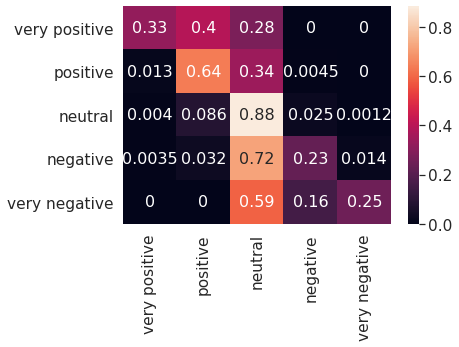

In [77]:
from sklearn.metrics import plot_confusion_matrix
labels_arr = np.array(('very positive','positive','neutral','negative','very negative'))
#print('\nConfusion matrix:\n',confusion_matrix(test_labels, predictions, labels= labels_arr))

import seaborn as sn


array = confusion_matrix(test_labels, predictions, labels =labels_arr, normalize='true')

df_cm = pd.DataFrame(array, labels_arr, labels_arr)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()


In [ ]:
normalize=normalize

In [ ]:
# train_data['sentiment.subjectivity']

In [ ]:
# numeric_features = train_data['sentiment.subjectivity']
# numeric_transformer = Pipeline(steps=[
#     ('imputer', Imputer(strategy='constant')),
#     ('scaler', StandardScaler())])

# text_features = train_data['body']
# text_transformer = TfidfVectorizer(max_features=1000, sublinear_tf= True, strip_accents = 'unicode')

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('tfidf_1', text_transformer, 'body'),
#         # ('tfidf_2', text_transformer, ['subreddit']),
#         # ('tfidf_3', text_transformer, ['majority_type'])],
#         ],remainder='drop')


In [159]:
# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('classifier', LogisticRegression(solver='saga', max_iter=15000, C=10, random_state= 0))])

In [ ]:
# clf.fit(train_data, train_labels)